In [1]:
%matplotlib notebook

import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lib.motion as motion

In [2]:
n = 64
batch_size = 100

# Set up model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/automap64-clean/cp-0200.ckpt')

In [3]:
# Set up corrupted model
corrupted_3_15_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_3_15_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_3_15_model.load_weights('training/automap64-3px-k15-pretrain/cp-0200.ckpt')

In [4]:
# Set up corrupted model
corrupted_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_model.load_weights('training/automap64-random/cp-0200.ckpt')

In [5]:
# Set up corrupted pretrained model
corrupted_pretrain_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_pretrain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_pretrain_model.load_weights('training/automap64-random-pretrain/cp-0200.ckpt')

In [6]:
num_pix = 8
k_line = 40

data_path = '/data/ddmg/voxelmorph/data/t1_mix/proc/old/resize256-crop_0/train/vols/ADNI_ADNI-1.5T-FS-5.3-Long_82180.long.023_S_0926_base_norm.npz'
vol_data = np.load(data_path)['vol_data']
_,_,z = vol_data.shape

img_data = vol_data[:,:,int(z/2)]
img_data = np.array(Image.fromarray(img_data).resize((n,n)))
img_data = img_data-img_data.mean()
img_data = img_data/np.max(img_data)

_,corrupted_img,corrupted_k_raw = motion.add_horiz_translation(img_data,num_pix,k_line,return_k=True)

corrupted_k_all = np.expand_dims(corrupted_k_raw,-1)
corrupted_k_re = np.real(corrupted_k_all)
corrupted_k_im = np.imag(corrupted_k_all)
corrupted_k = np.expand_dims(np.concatenate([corrupted_k_re,corrupted_k_im], axis=2), axis=0)

<IPython.core.display.Javascript object>


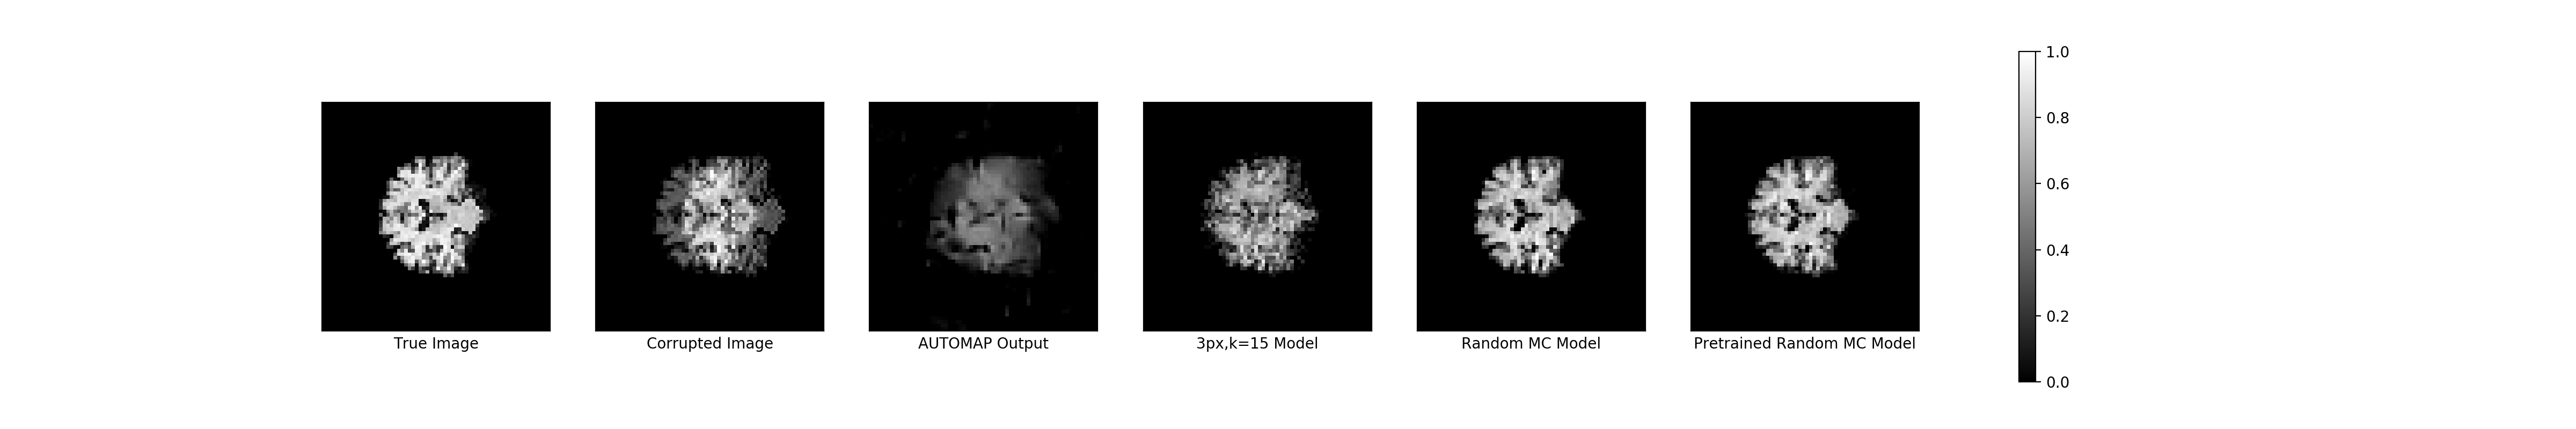

In [7]:
fig,axes = plt.subplots( 1,6, figsize=[24,4] )
for i,iax in enumerate(axes.flatten()):
    if i==0:
        true_img = img_data
        im = iax.imshow(true_img,cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('True Image')
    elif i==1:
        corrupted_img = (np.real(corrupted_img))
        im = iax.imshow(corrupted_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Corrupted Image')
    elif i==2:
        im = iax.imshow(model.predict(corrupted_k)[0,:,:,0],cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('AUTOMAP Output')
    elif i==3:
        corrupted_3_15_predict = corrupted_3_15_model.predict(corrupted_k)[0,:,:,0]
        im = iax.imshow(np.real(corrupted_3_15_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('3px,k=15 Model')
    elif i==4:
        corrupted_predict = corrupted_model.predict(corrupted_k)[0,:,:,0]
        im = iax.imshow(corrupted_predict,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Random MC Model')
    elif i==5:
        corrupted_pretrain_predict = corrupted_pretrain_model.predict(corrupted_k)[0,:,:,0]
        im = iax.imshow(np.real(corrupted_pretrain_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Pretrained Random MC Model')
        
fig.colorbar(im, ax=axes.ravel().tolist())